# Predicting Car Prices

# ------------------------- Task 1-----------------------------

#### Mlflow

In [384]:
#experiment tracking
import mlflow
import os
# This the dockerized method.
# We build two docker containers, one for python/jupyter and another for mlflow.
# The url `mlflow` is resolved into another container within the same composer.
mlflow.set_tracking_uri("http://localhost:5000") # URL of the MLflow server
# If your MLflow server requires authentication, set these environment variables:
# os.environ["MLFLOW_TRACKING_USERNAME"] = "your_username"
# os.environ["MLFLOW_TRACKING_PASSWORD"] = "your_password"

os.environ["LOGNAME"] = "mastersubhajit" # Set your desired username here

# Try to create the experiment if it does not exist

mlflow.set_experiment(experiment_name="cppm-a2")

<Experiment: artifact_location='mlflow-artifacts:/667924426946015256', creation_time=1757229974549, experiment_id='667924426946015256', last_update_time=1757229974549, lifecycle_stage='active', name='cppm-a2', tags={}>

#### Importing Libraries

In [385]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## 1. Load Data

In [386]:
df = pd.read_csv("data/Cars.csv")

In [387]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.00
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.00
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.00
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.00
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.00


In [388]:
df.shape

(8128, 13)

In [389]:
df.describe()

,year,selling_price,km_driven,seats
count,8000.00,8000.00,8000.00,7000.00
mean,2000.00,600000.00,60000.00,5.00
std,4.00,800000.00,50000.00,0.90
min,1000.00,20000.00,1.00,2.00
25%,2000.00,200000.00,30000.00,5.00
50%,2000.00,400000.00,60000.00,5.00
75%,2000.00,600000.00,90000.00,5.00
max,2000.00,10000000.00,2000000.00,10.00


In [390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 800.0+ KB


## 2. Exploratory Data Analysis

In [391]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

In [392]:
print("Missing values per column:\n", df.isna().sum().sort_values(ascending=False)) # Checking for missing values

Missing values per column:
 torque           222
mileage          221
engine           221
seats            221
max_power        215
name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
dtype: int64


## 2. Feature Engineering

#### 2.1. Feature Owner

In [393]:
df.owner.unique()

array(['First Owner', 'Second Owner', 'Third Owner',
       'Fourth & Above Owner', 'Test Drive Car'], dtype=object)

In [394]:
owner_map = {
    "First Owner": 1,
    "Second Owner": 2,
    "Third Owner": 3,
    "Fourth & Above Owner": 4,
    "Test Drive Car": 5
}

In [395]:
if "owner" in df.columns:
    df['owner'] = df['owner'].map(owner_map) # Mapping owner categories to numerical values
else:
    raise ValueError("Expected 'owner' column not found.")

In [396]:
df.owner.unique()

array([1, 2, 3, 4, 5])

#### 2.2. Feature Fuel

In [397]:
df = df[~df['fuel'].isin(['CNG', 'LPG'])].reset_index(drop=True) # Removing rows with CNG and LPG

#### 2.3. Feature Mileage

In [398]:
df['mileage'] = df['mileage'].str.split().str[0] # Extract the numeric part of mileage
df['mileage'] = df['mileage'].astype(float)

In [399]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,20.00,1248 CC,74 bhp,190Nm@ 2000rpm,5.00
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,20.00,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.00
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,10.00,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.00
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,20.00,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.00
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,10.00,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.00


#### 2.4. Feature Engine

In [400]:
df['engine'] = df['engine'].str.split().str[0]
df['engine'] = df['engine'].astype(float)

In [401]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,20.00,1000.00,74 bhp,190Nm@ 2000rpm,5.00
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,20.00,1000.00,103.52 bhp,250Nm@ 1500-2500rpm,5.00
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,10.00,1000.00,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.00
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,20.00,1000.00,90 bhp,22.4 kgm at 1750-2750rpm,5.00
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,10.00,1000.00,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.00


#### 2.5. Feature Max-Power

In [402]:
df['max_power'] = df['max_power'].str.split().str[0]
df['max_power'] = df['max_power'].astype(float)

In [403]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,20.00,1000.00,70.00,190Nm@ 2000rpm,5.00
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,20.00,1000.00,100.00,250Nm@ 1500-2500rpm,5.00
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,10.00,1000.00,70.00,"12.7@ 2,700(kgm@ rpm)",5.00
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,20.00,1000.00,90.00,22.4 kgm at 1750-2750rpm,5.00
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,10.00,1000.00,80.00,"11.5@ 4,500(kgm@ rpm)",5.00


#### 2.6. Feature Brand

In [404]:
df['name'] = df['name'].str.split().str[0] # Extract the brand from the name

In [405]:
df = df.rename(columns={'name': 'brand'}) # Renaming 'name' column to 'brand'
df.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,20.00,1000.00,70.00,190Nm@ 2000rpm,5.00
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,20.00,1000.00,100.00,250Nm@ 1500-2500rpm,5.00
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,10.00,1000.00,70.00,"12.7@ 2,700(kgm@ rpm)",5.00
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,20.00,1000.00,90.00,22.4 kgm at 1750-2750rpm,5.00
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,10.00,1000.00,80.00,"11.5@ 4,500(kgm@ rpm)",5.00


#### 2.7. Feature Torque

In [406]:
df = df.drop(columns=['torque'])
df.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,20.00,1000.00,70.00,5.00
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,20.00,1000.00,100.00,5.00
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,10.00,1000.00,70.00,5.00
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,20.00,1000.00,90.00,5.00
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,10.00,1000.00,80.00,5.00


#### 2.8. Feature Owner - Drop Test Drive Cars

In [407]:
df = df[df['owner'] != 5] # Removing Test Drive Cars

## 3. Exploratory Data Analysis

In [408]:
df.columns

Index(['brand', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats'],
      dtype='object')

In [409]:
print("Missing values per column:\n", df.isna().sum().sort_values(ascending=False)) # Checking for missing values

Missing values per column:
 mileage          214
engine           214
seats            214
max_power        208
brand              0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
dtype: int64


### Label Encoding

In [410]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['brand', 'seller_type', 'transmission', 'fuel']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on all unique values in the column
    df[col] = df[col].astype(str)
    le.fit(df[col])
    label_encoders[col] = le
    df[col] = le.transform(df[col])

#### 3.1. Univariate Analysis
#### Countplot

<Axes: xlabel='fuel', ylabel='count'>

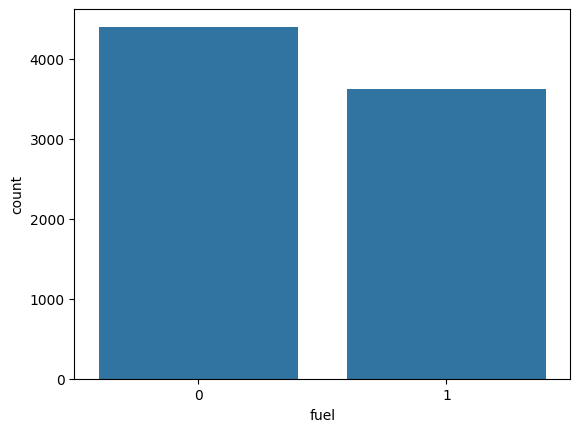

In [411]:
sns.countplot(data = df, x = 'fuel')

<Axes: xlabel='transmission', ylabel='count'>

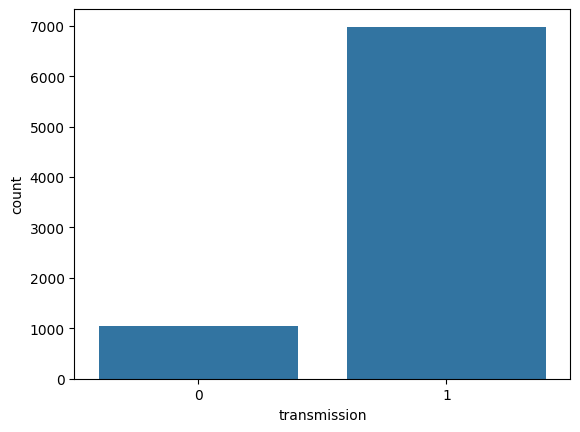

In [412]:
sns.countplot(data = df, x = 'transmission')

<Axes: xlabel='owner', ylabel='count'>

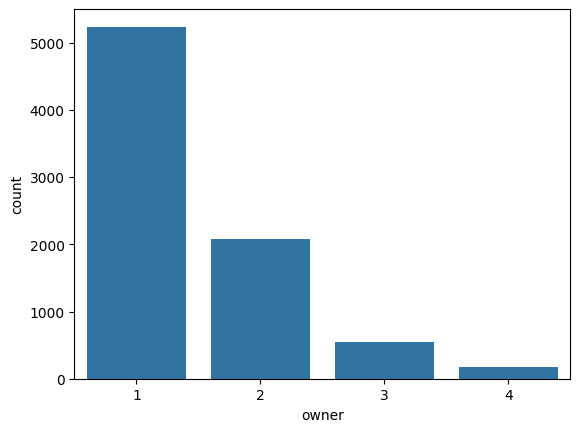

In [413]:
sns.countplot(data = df, x = 'owner')

#### Distribution Plot

<Axes: xlabel='mileage', ylabel='Count'>

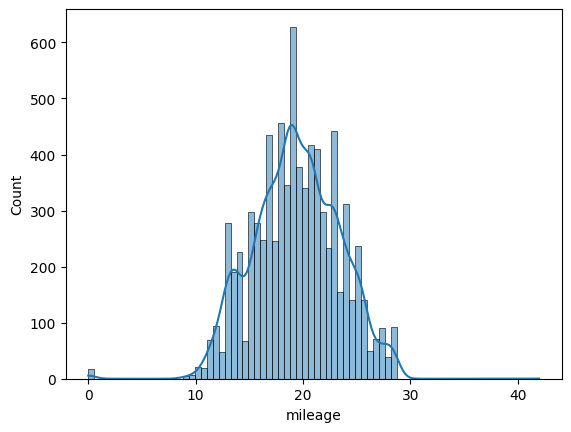

In [414]:
sns.histplot(data = df, x = 'mileage', kde=True)

<Axes: xlabel='km_driven', ylabel='Count'>

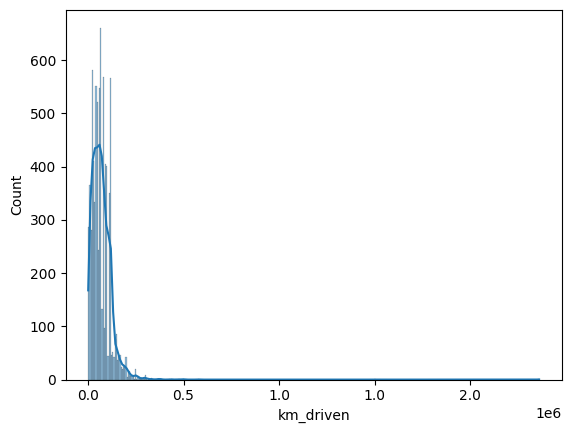

In [415]:
sns.histplot(data = df, x = 'km_driven', kde=True)

<Axes: xlabel='selling_price', ylabel='Count'>

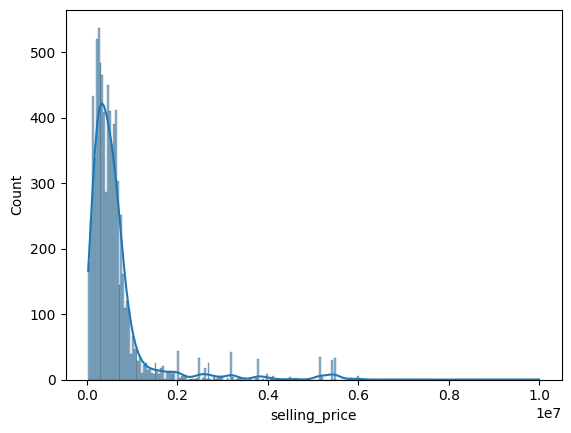

In [416]:
sns.histplot(data = df, x = 'selling_price', kde=True)

#### 3.2. Multivariate Analysis
#### Boxplot

Text(0, 0.5, 'Selling Price')

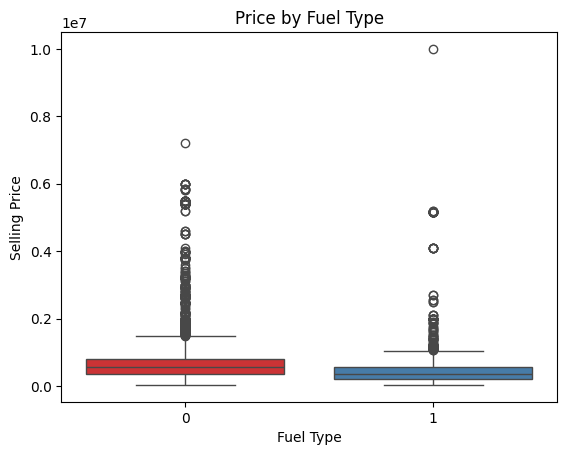

In [417]:
sns.boxplot(data=df, x='fuel', y='selling_price', palette='Set1')
plt.title('Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Selling Price')

Text(0, 0.5, 'Selling Price')

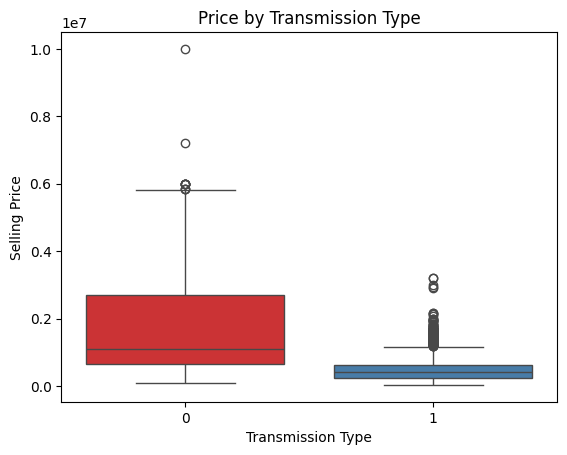

In [418]:
sns.boxplot(data=df, x='transmission', y='selling_price', palette='Set1')
plt.title('Price by Transmission Type')
plt.xlabel('Transmission Type')
plt.ylabel('Selling Price')

Text(0, 0.5, 'Selling Price')

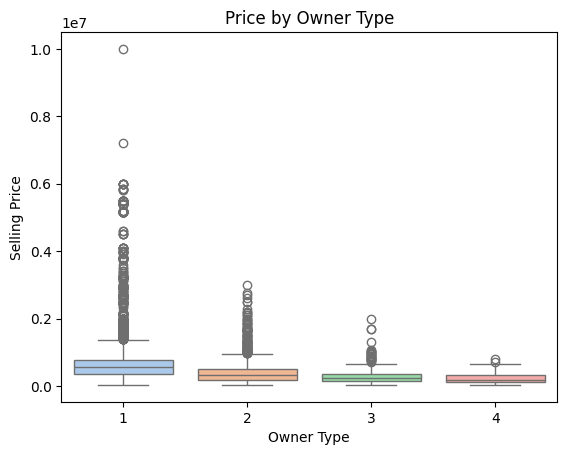

In [419]:
sns.boxplot(data=df, x='owner', y='selling_price', palette='pastel')
plt.title('Price by Owner Type')
plt.xlabel('Owner Type')
plt.ylabel('Selling Price')

Text(0, 0.5, 'Selling Price')

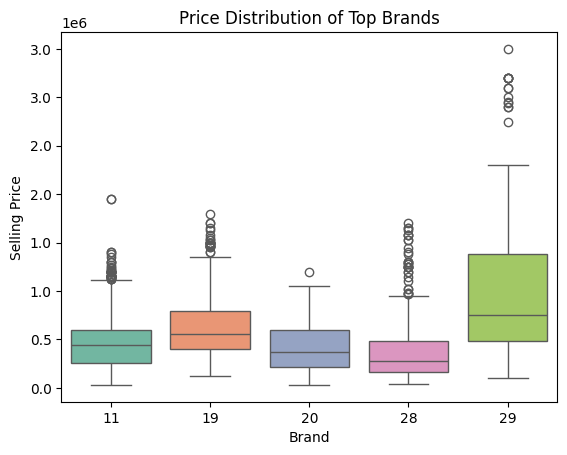

In [420]:
top_brands = df['brand'].value_counts().nlargest(5).index
sns.boxplot(x='brand', y='selling_price', data=df[df['brand'].isin(top_brands)],
            palette='Set2')
plt.title('Price Distribution of Top Brands')
plt.xlabel('Brand')
plt.ylabel('Selling Price')

#### Scatter Plot

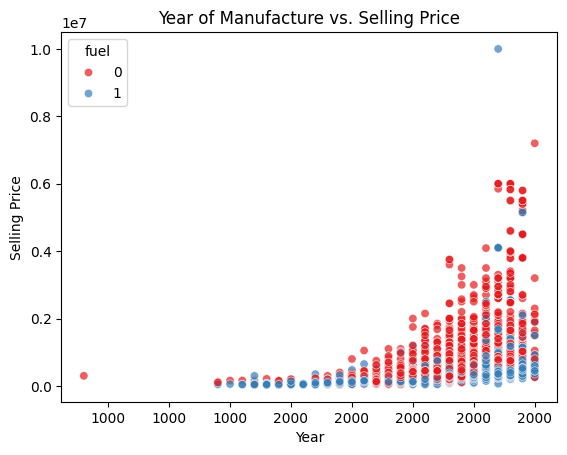

In [421]:
sns.scatterplot(x='year', y='selling_price', data=df, hue='fuel', palette='Set1', alpha=0.7)
plt.title('Year of Manufacture vs. Selling Price')
plt.xlabel('Year')
plt.ylabel('Selling Price')
plt.show()

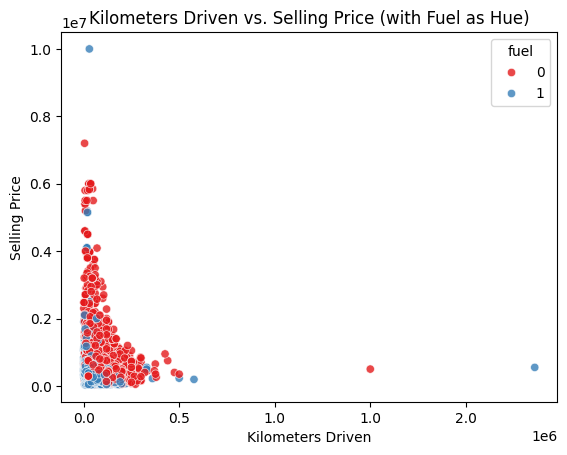

In [422]:
sns.scatterplot(x='km_driven', y='selling_price', data=df, hue='fuel', palette='Set1', alpha=0.8)
plt.title('Kilometers Driven vs. Selling Price (with Fuel as Hue)')
plt.xlabel('Kilometers Driven')
plt.ylabel('Selling Price')
plt.show()

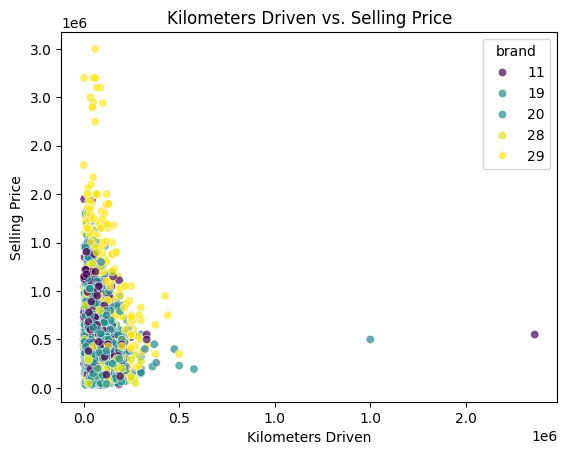

In [423]:
top_brands = df['brand'].value_counts().nlargest(5).index
sns.scatterplot(data=df[df['brand'].isin(top_brands)], x='km_driven', y='selling_price', hue='brand', palette='viridis', alpha=0.7)
plt.title('Kilometers Driven vs. Selling Price')
plt.xlabel('Kilometers Driven')
plt.ylabel('Selling Price')
plt.show()

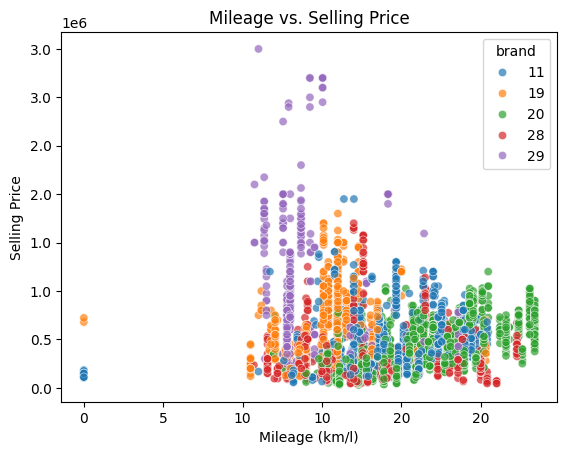

In [424]:
top_brands = df['brand'].value_counts().nlargest(5).index
sns.scatterplot(data=df[df['brand'].isin(top_brands)], x='mileage', y='selling_price', hue='brand', palette='tab10', alpha=0.7)
plt.title('Mileage vs. Selling Price')
plt.xlabel('Mileage (km/l)')
plt.ylabel('Selling Price')
plt.show()

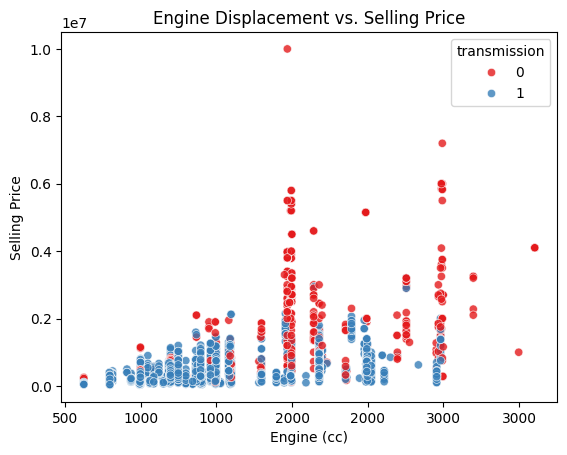

In [425]:
sns.scatterplot(data=df, x='engine', y='selling_price', hue='transmission', palette='Set1', alpha=0.8)
plt.title('Engine Displacement vs. Selling Price')
plt.xlabel('Engine (cc)')
plt.ylabel('Selling Price')
plt.show()

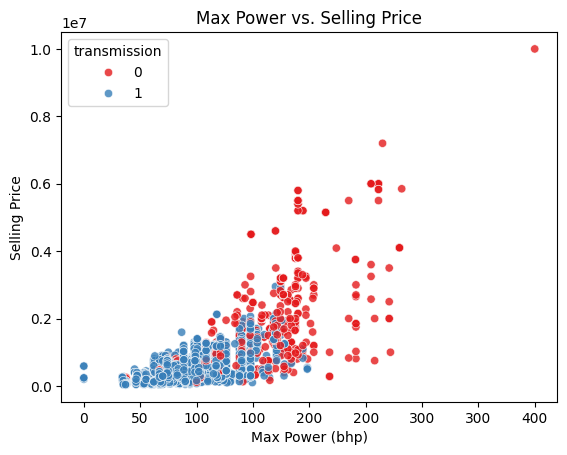

In [426]:
sns.scatterplot(data=df, x='max_power', y='selling_price', hue='transmission', palette='Set1', alpha=0.8)
plt.title('Max Power vs. Selling Price')
plt.xlabel('Max Power (bhp)')
plt.ylabel('Selling Price')
plt.show()

#### Correlation Matrix

<Axes: >

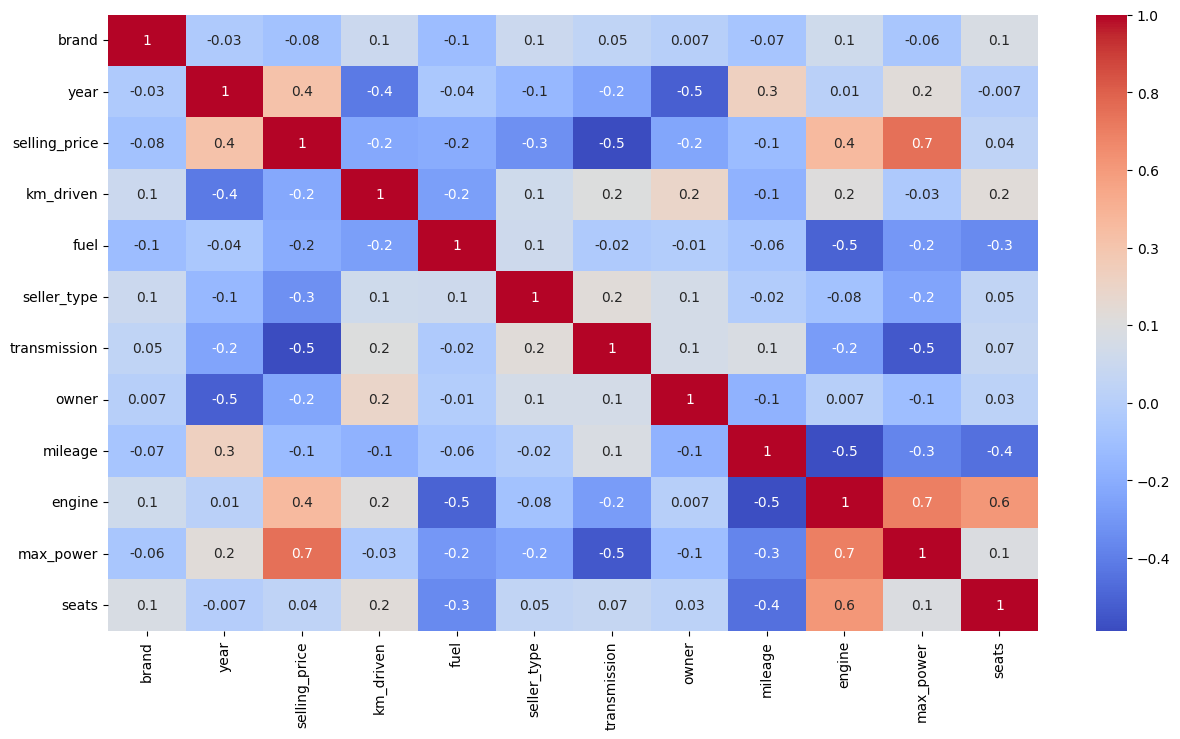

In [427]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

#### Predictive Power Score

<Axes: xlabel='x', ylabel='y'>

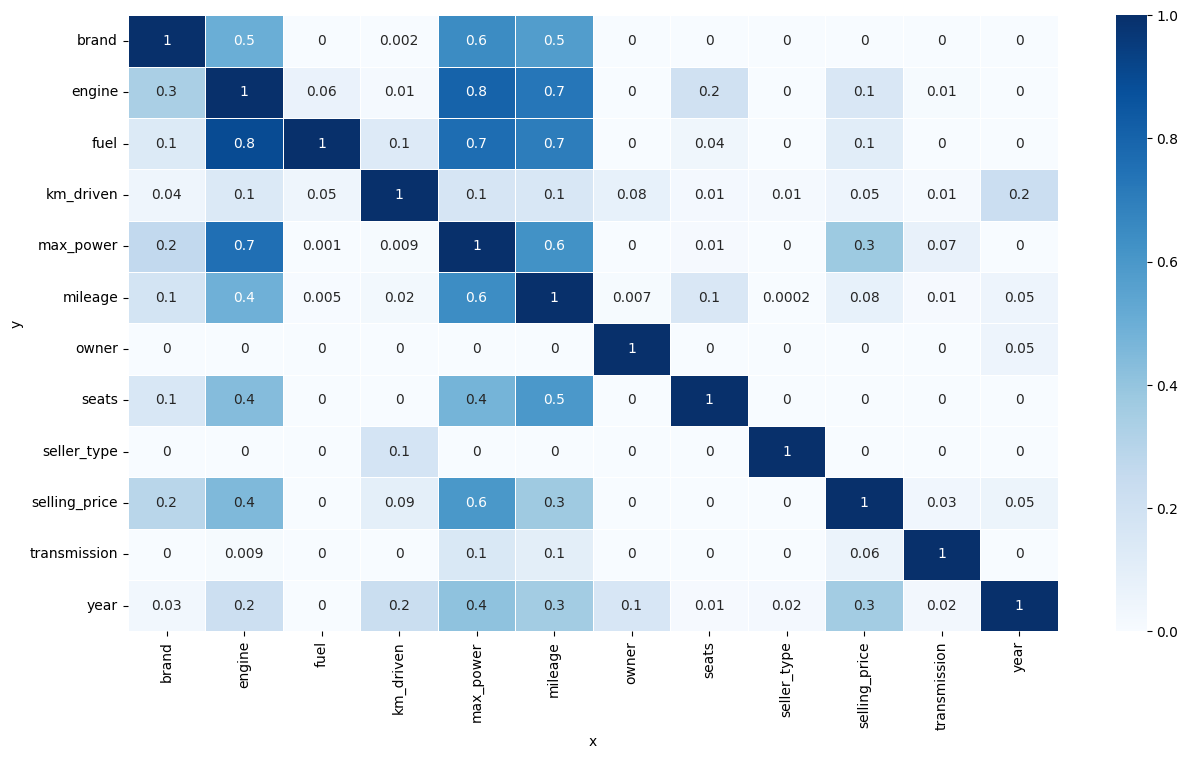

In [428]:
#Importing the ppscore
import ppscore as pps

dfcopy = df.copy()

# Some minor preprocessing is done because seaborn.heatmap unfortunately does not accept tidy data
matrix_df = pps.matrix(dfcopy).pivot(columns='x', index='y', values='ppscore')

# The Predictive power score graph is plotted
plt.figure(figsize = (15,8))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

## 4. Feature Selection

In [429]:
X = df[['year', 'max_power', 'mileage']] # Important Features
y = np.log(df['selling_price']) # Target Variable

### Train & Test Split

In [430]:
from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [431]:
df.describe()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
count,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,7000.00,7000.00,7000.00,7000.00
mean,10.00,2000.00,600000.00,60000.00,0.40,0.80,0.80,1.00,10.00,1000.00,90.00,5.00
std,7.00,4.00,800000.00,50000.00,0.40,0.30,0.30,0.70,4.00,500.00,30.00,0.90
min,0.00,1000.00,20000.00,1000.00,0.00,0.00,0.00,1.00,0.00,600.00,0.00,2.00
25%,10.00,2000.00,200000.00,30000.00,0.00,1.00,1.00,1.00,10.00,1000.00,60.00,5.00
50%,20.00,2000.00,400000.00,60000.00,0.00,1.00,1.00,1.00,10.00,1000.00,80.00,5.00
75%,20.00,2000.00,600000.00,90000.00,1.00,1.00,1.00,2.00,20.00,1000.00,100.00,5.00
max,30.00,2000.00,10000000.00,2000000.00,1.00,2.00,1.00,4.00,40.00,3000.00,400.00,10.00


In [432]:
print("Log-transformed target stats:", y.describe())

Log-transformed target stats: count   8000.00
mean      10.00
std        0.80
min       10.00
25%       10.00
50%       10.00
75%       10.00
max       10.00
Name: selling_price, dtype: float64


In [433]:
df.to_csv("data/Cleaned_Cars.csv", sep=",", index=False, encoding='utf-8') # Saving the cleaned dataset

## 5. Data Preprocessing

In [434]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6422, 3)
X_test shape: (1606, 3)
y_train shape: (6422,)
y_test shape: (1606,)


In [435]:
X_train[['year', 'max_power', 'mileage']].isna().sum()

year           0
max_power    165
mileage      171
dtype: int64

In [436]:
X_test[['year', 'max_power', 'mileage']].isna().sum()

year          0
max_power    43
mileage      43
dtype: int64

In [437]:
y_train.isna().sum()

np.int64(0)

In [438]:
y_test.isna().sum()

np.int64(0)

In [439]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6422 entries, 2948 to 7275
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       6422 non-null   int64  
 1   max_power  6257 non-null   float64
 2   mileage    6251 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 200.0 KB


#### Verifying the distribution of all the missing values

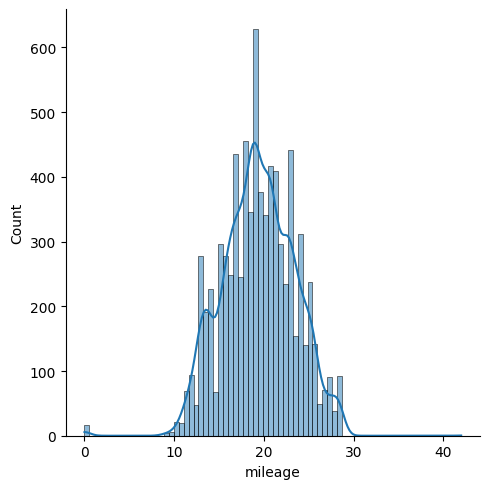

In [440]:
sns.displot(data=df,x='mileage', kde=True)

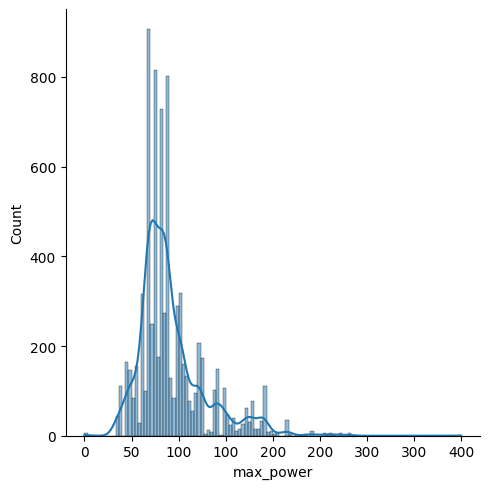

In [441]:
sns.displot(data=df, x='max_power', kde=True)

In [442]:
# Continuous features → use median
X_train['mileage'].fillna(X_train['mileage'].mean(), inplace=True)
X_test['mileage'].fillna(X_train['mileage'].mean(), inplace=True)  # use train's mean, not test's own!

X_train['max_power'].fillna(X_train['max_power'].mean(), inplace=True)
X_test['max_power'].fillna(X_train['max_power'].mean(), inplace=True)

In [443]:
X_train['mileage'].mean()

np.float64(19.383089105743082)

In [444]:
X_train['max_power'].mean()

np.float64(91.78763944382293)

In [445]:
# Remove rows with NA values in y_train and y_test
y_train_rows_with_na = y_train.isna()
y_train = y_train[~y_train_rows_with_na]
X_train = X_train[~y_train_rows_with_na]

y_test_rows_with_na = y_test.isna()
X_test = X_test[~y_test_rows_with_na]
y_test = y_test[~y_test_rows_with_na]

In [446]:
X_train[['year', 'max_power', 'mileage']].isna().sum() # Checking for missing values in feature variables

year         0
max_power    0
mileage      0
dtype: int64

In [447]:
X_test[['year', 'max_power', 'mileage']].isna().sum() # Checking for missing values in feature variables

year         0
max_power    0
mileage      0
dtype: int64

In [448]:
y_test.isna().sum(), y_train.isna().sum() # Checking for missing values in target variables

(np.int64(0), np.int64(0))

#### 5.1. Checking Outliers

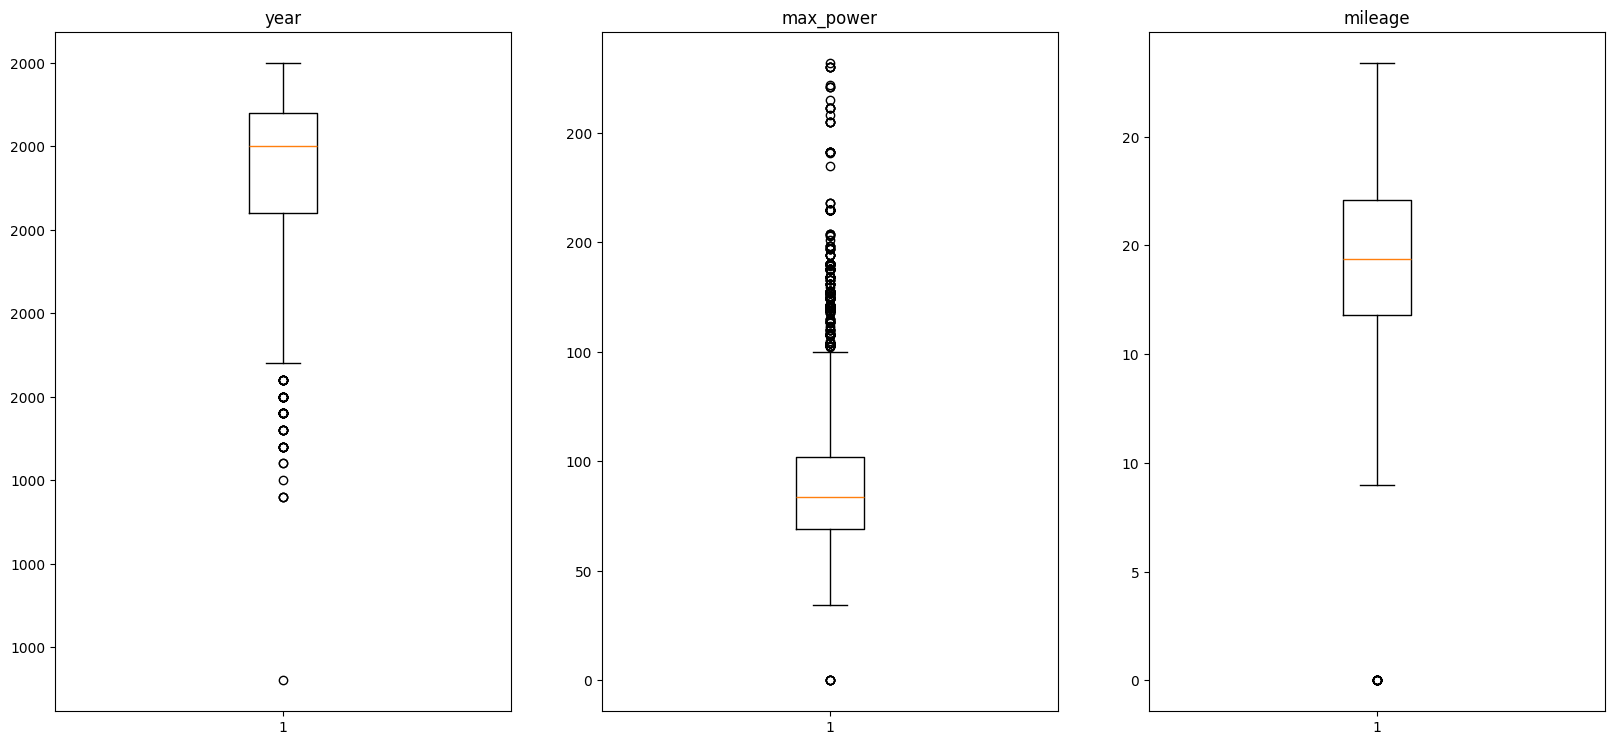

In [449]:
col_dict = {
    'year': 1,
    'max_power': 2,
    'mileage': 3
}

# Detecting outliers in each variable using box plots.
plt.figure(figsize=(20, 30))

#Looping through col_dict
for variable, i in col_dict.items():
    # Creating subplots within a large figures. the arguments 3 and 3 spethat the figure should have a grid of 3 rows and 3 columns of subplots. While the argument i specifies the current position of the subplot within the grid, based on the values from col_dict
    plt.subplot(3, 3, i)
    plt.boxplot(X_train[variable])
    # Setting the title of the current subplot to the name of the column (variable) being visualized.
    plt.title(variable)

plt.show()

In [450]:
# Defining a function to calculate the outliers in each features as it will decrease data quality in turn the efficiency of our model will also be negatively impacted
def outlier_count(col, data = X_train):
    
    # Calculating Q1 and Q3
    q75, q25 = np.percentile(data[col], [75, 25])
    
    # calculating the interquartile range
    iqr = q75 - q25
    
    # Calculating the minimum and maximum value
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    # Counting the number of outliers, which are the data that are less than min_val or more than max_val which have been calculated above
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    
    # Calculating the percentage of the outliers
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    
    # Checking to see if any outliers are present and printing information about the same
    if(outlier_count > 0):
        print("\n"+15*'-' + col + 15*'-'+"\n")
        print('Number of outliers: {}'.format(outlier_count))
        print('Percent of data that is outlier: {}%'.format(outlier_percent))

In [451]:
# Printing all the outliers in each of the features
for col in X_train.columns:
    outlier_count(col, data=X_train)  # Pass the DataFrame, not the numpy array


---------------year---------------

Number of outliers: 63
Percent of data that is outlier: 0.9%

---------------max_power---------------

Number of outliers: 459
Percent of data that is outlier: 7.0%

---------------mileage---------------

Number of outliers: 16
Percent of data that is outlier: 0.2%


#### 5.2. Scaling

In [452]:
from sklearn.preprocessing import StandardScaler
# Initialize the scaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [453]:
# Verifying the shape of all X_train, X_test, Y_train and Y_test

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (6422, 3)
Shape of X_test:  (1606, 3)
Shape of y_train:  (6422,)
Shape of y_test:  (1606,)


## 6. Modeling

### 6.1 Cross Validation

In [454]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

class LinearRegression(object):
    
    def __init__(self, regularization, lr=0.001, method='batch', init='xavier', polynomial=True, degree=2,
                 use_momentum=True, momentum=0.5, num_epochs=500, batch_size=50, cv=KFold(n_splits=3)):
        
        # Model Hyperparameters
        self.lr         = lr                     # Learning rate, controls how big of a step the model takes
        self.num_epochs = num_epochs             # Number of times the model will go through the entire dataset
        self.batch_size = batch_size             # Number of samples in each training batch
        self.method     = method                 # Gradient descent method: 'batch', 'mini', 'sto'
        self.polynomial = polynomial             # Whether to use polynomial features
        self.degree     = degree                 # The highest power for polynomial features
        self.init       = init                   # Method for initializing the model's weights: 'zeros', 'xavier'
        self.use_momentum   = use_momentum       # Whether to use momentum to speed up training
        self.momentum   = momentum               # Momentum rate
        self.prev_step  = 0                      # Keeps track of the previous step for momentum calculations
        self.cv         = cv                     # Cross-validation strategy, used to split data into folds
        self.regularization = regularization     # The regularization object (L1, L2, etc.)

        # Model Attributes
        self.theta = None                        # The model's weights, which are learned during training
        self.poly_transformer = None             # Stores the polynomial feature transformer
        self.kfold_scores = []                   # List to store the MSE for each cross-validation fold
        self.kfold_r2 = []                       # List to store the R2 score for each fold
        self.val_loss_old = np.inf               # Used for early stopping
        self.columns = None
        self.feature_names = None

    def mse(self, ytrue, ypred):  # Calculates the Mean Squared Error between true and predicted values
        ytrue = np.array(ytrue).reshape(-1)
        ypred = np.array(ypred).reshape(-1)
        return mean_squared_error(ytrue, ypred)
    
    def r2(self, ytrue, ypred):  # Calculates the R-squared score, which measures how well the model's predictions fit the data
        return r2_score(ytrue, ypred)
    
    def avgMSE(self): # Returns the average MSE across all cross-validation folds
        return np.mean(self.kfold_scores)
    
    def avgr2(self): # Returns the average R-squared score across all cross-validation folds
        return np.mean(self.kfold_r2)
    
    def _init_weights(self, n_features):
        if self.init == "xavier":
            limit = np.sqrt(6.0 / (n_features + 1))
            return np.random.uniform(-limit, limit, size=n_features)
        elif self.init == "zero":
            return np.zeros(n_features)
        else:
            raise ValueError("init must be either 'zero' or 'xavier'")


    def _transform_data(self, X): # Prepares the input data for the model
        if self.polynomial:  # If a transformer doesn't exist yet, we create and fit it to the data
            if self.poly_transformer is None:
                self.poly_transformer = PolynomialFeatures(degree=self.degree, include_bias=False)
                X = self.poly_transformer.fit_transform(X)
            else:
                X = self.poly_transformer.transform(X) # Use the existing transformer to transform the data
        return np.c_[np.ones(X.shape[0]), X]    # We add a bias (intercept) column to the data to allow the model to learn a baseline value
    
    def fit(self, X_train, y_train):        # The main function to train the model on your data
        
        self.kfold_scores = []
        self.kfold_r2 = []
        self.val_loss_old = np.inf

        if isinstance(X_train, pd.DataFrame):
            self.feature_names = X_train.columns.tolist()
            X_train = X_train.values
        else:
            self.feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
            
        if isinstance(y_train, pd.Series):
            y_train = y_train.values
        if self.polynomial and self.poly_transformer is None:                   # We prepare the polynomial features on the entire dataset first, which is more efficient
            self.poly_transformer = PolynomialFeatures(degree=self.degree, include_bias=False)
            X_train_poly = self.poly_transformer.fit_transform(X_train)
        elif self.polynomial:
            X_train_poly = self.poly_transformer.transform(X_train)
        else:
            X_train_poly = X_train

        for fold, (train_idx, val_idx) in enumerate(self.cv.split(X_train_poly)):    # The rest of the logic proceeds with the transformed but not re-scaled data
            X_cross_train, X_cross_val = X_train_poly[train_idx], X_train_poly[val_idx]
            y_cross_train, y_cross_val = y_train[train_idx], y_train[val_idx]
            
            # We add a bias column to both the training and validation sets for the model
            X_cross_train = np.c_[np.ones(X_cross_train.shape[0]), X_cross_train]
            X_cross_val = np.c_[np.ones(X_cross_val.shape[0]), X_cross_val]

            self.theta = self._init_weights(X_cross_train.shape[1])
            self.vel = np.zeros_like(self.theta)
            
            with mlflow.start_run(run_name=f"Fold-{fold}", nested=True):
                params = {"method": self.method, "lr": self.lr, "reg": type(self).__name__,
                          "init": self.init, "momentum": self.momentum, "poly_degree": self.degree}
                mlflow.log_params(params=params)

                for epoch in range(self.num_epochs):
                    perm = np.random.permutation(X_cross_train.shape[0])
                    X_cross_train_shuffled = X_cross_train[perm]
                    y_cross_train_shuffled = y_cross_train[perm]
                    
                    if self.method == 'sto':
                        for batch_idx in range(X_cross_train.shape[0]):
                            X_method_train = X_cross_train_shuffled[batch_idx].reshape(1, -1)
                            y_method_train = y_cross_train_shuffled[batch_idx]
                            train_loss = self._train(X_method_train, y_method_train)
                    elif self.method == 'mini':
                        for batch_idx in range(0, X_cross_train.shape[0], self.batch_size):
                            X_method_train = X_cross_train_shuffled[batch_idx:batch_idx+self.batch_size]
                            y_method_train = y_cross_train_shuffled[batch_idx:batch_idx+self.batch_size]
                            train_loss = self._train(X_method_train, y_method_train)
                    else:
                        train_loss = self._train(X_cross_train_shuffled, y_cross_train_shuffled)
                    
                    mlflow.log_metric(key="train_loss", value=train_loss, step=epoch)

                    yhat_val = self.predict(X_cross_val, from_train=True)
                    val_loss_new = self.mse(y_cross_val, yhat_val)
                    val_r2_new = self.r2(y_cross_val, yhat_val)
                    
                    mlflow.log_metric(key="val_loss", value=val_loss_new, step=epoch)
                    mlflow.log_metric(key="val_r2", value=val_r2_new, step=epoch)

                    if np.allclose(val_loss_new, self.val_loss_old):
                        break
                    self.val_loss_old = val_loss_new
                
                self.kfold_scores.append(val_loss_new)
                self.kfold_r2.append(val_r2_new)
                print(f"Fold {fold}: MSE {val_loss_new}")
                print(f"Fold {fold}: R2: {val_r2_new}")
    
    def _train(self, X, y):
        yhat = X @ self.theta
        m = X.shape[0]

        grad = (1/m) * X.T @ (yhat - y)

        if self.regularization is not None:
            reg_grad = self.regularization.derivation(self.theta).copy()    # Get the gradient from the regularization object
            reg_grad[0] = 0  # don’t regularize bias
            grad += reg_grad # Add the regularization gradient to the main gradient

        if self.use_momentum:   # Update weights with momentum
            self.vel = self.momentum * self.vel + self.lr * grad    # Update velocity
            self.theta = self.theta - self.vel  # Update weights using velocity
        else:
            self.theta = self.theta - self.lr * grad    # Update weights without momentum

        return self.mse(y, yhat)    # Return the training loss for this batch
    
    def predict(self, X, from_train=False): # Makes predictions on new data.
        if not from_train:                  # It handles transforming the data before making a prediction.
            if self.polynomial:
                X = self.poly_transformer.transform(X)  # Transform the data if polynomial features are used
            X = np.c_[np.ones(X.shape[0]), X]       # Add the bias column to the data
            
        return X @ self.theta
     
    def _coef(self):
        return self.theta[1:] # Returns the learned coefficients (weights) of the model, excluding the bias term
    
    def _bias(self):
        return self.theta[0]  # Returns the learned bias (intercept) of the model
    
    # def feature_importance(self, width=5, height=10):  # Creates a bar chart showing the importance of each feature
    #     #if self.theta is not None and self.columns is not None:  # Skip bias term when plotting
    #         coefs = pd.DataFrame(
    #             data=self.theta[1:],
    #             columns=['Coefficients'],
    #             index=self.columns
    #         )
    #         coefs.plot(kind="barh", figsize=(width, height))
    #         plt.title("Feature Importance")
    #         plt.show()
    #     else:
    #         print("Coefficients or feature names are not available to create the graph.")
    def feature_importance(self, width=5, height=10):
        if self.theta is not None and self.feature_names is not None:
            coefs = pd.DataFrame(
                data=self.theta[1:],  # skip bias
                columns=['Coefficients'],
                index=self.feature_names if not self.polynomial else range(len(self.theta[1:]))
            )
            coefs.plot(kind="barh", figsize=(width, height))
            plt.title("Feature Importance")
            plt.show()
        else:
            print("Coefficients or feature names are not available to create the graph.")

#### Penalty for L1, L2 and L1 & L2 Regression Models

In [455]:
# Defining penalty classes for different regularization techniques
class LassoPenalty:
    
    def __init__(self, l):
        self.l = l # lambda value
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.abs(theta))
        
    def derivation(self, theta):
        return self.l * np.sign(theta) # Derivative of L1 norm is lambda*sign(theta)
    
class RidgePenalty:
    
    def __init__(self, l):
        self.l = l
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.square(theta)) 
        
    def derivation(self, theta):
        return self.l * 2 * theta # Derivative of L2 norm is 2*lambda*theta
    
class ElasticPenalty:
    
    def __init__(self, l = 0.1, l_ratio = 0.5):
        self.l = l 
        self.l_ratio = l_ratio

    def __call__(self, theta):  #__call__ allows us to call class as method
        l1_contribution = self.l_ratio * self.l * np.sum(np.abs(theta)) # L1 part
        l2_contribution = (1 - self.l_ratio) * self.l * 0.5 * np.sum(np.square(theta)) # 0.5 factor for L2
        return (l1_contribution + l2_contribution)

    def derivation(self, theta):
        l1_derivation = self.l * self.l_ratio * np.sign(theta)
        l2_derivation = self.l * (1 - self.l_ratio) * theta
        return (l1_derivation + l2_derivation)
    
# Defining subclasses for different regularization techniques    
class Lasso(LinearRegression):
    def __init__(self, l, lr, method, init, polynomial, degree, use_momentum, momentum):
        self.regularization = LassoPenalty(l)
        super().__init__(self.regularization, lr, method, init, polynomial, degree, use_momentum, momentum)
    def avgMSE(self):
        return np.sum(np.array(self.kfold_scores)) / len(self.kfold_scores)

class Ridge(LinearRegression):
    def __init__(self, l, lr, method, init, polynomial, degree, use_momentum, momentum):
        self.regularization = RidgePenalty(l)
        super().__init__(self.regularization, lr, method, init, polynomial, degree, use_momentum, momentum)
    def avgMSE(self):
        return np.sum(np.array(self.kfold_scores)) / len(self.kfold_scores)

class ElasticNet(LinearRegression):
    def __init__(self, l, lr, method, init, polynomial, degree, use_momentum, momentum, l_ratio=0.5):
        self.regularization = ElasticPenalty(l, l_ratio)
        super().__init__(self.regularization, lr, method, init, polynomial, degree, use_momentum, momentum)
    def avgMSE(self):
        return np.sum(np.array(self.kfold_scores)) / len(self.kfold_scores)

class Normal(LinearRegression):
    def __init__(self, l, lr, method, init, polynomial, degree, use_momentum, momentum):
        self.regularization = None  # No regularization
        super().__init__(self.regularization, lr, method, init, polynomial, degree, use_momentum, momentum)
    def avgMSE(self):
        return np.sum(np.array(self.kfold_scores)) / len(self.kfold_scores)

In [456]:
import sys

def str_to_class(classname):    #converts string to class
    return getattr(sys.modules[__name__], classname)

#### Training L1, L2 and ElasticNet(L1 & L2)

In [457]:
regs = ["Ridge", "Lasso", "ElasticNet"]

# Looping through all regression methods
for reg in regs:
    # Specifying the parameters for the model
    params = {"method": "batch", "l": 0.1, "lr": 0.1,  "polynomial": True, "init" :"xavier", 
    "use_momentum" :True,  "momentum":0.5, "degree":2}
    mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-reg-{reg}", nested=True)
    
    print("="*5, reg, "="*5) # Printing the name of the regression method being used

    #Specifying the type of regression and setting up the model based on it
    type_of_regression = str_to_class(reg)    #Ridge, Lasso, ElasticNet
    model = type_of_regression(**params) # Creating the model object
    model.fit(X_train, y_train) # Fitting the model
    #Calculating avgMse and r2 for the speicified params
    mse = model.avgMSE()
    r2 = model.avgr2()

    yhat = model.predict(X_train)  # Predicting on the training data
    
    print("Validation MSE: ", mse)
    print("Validation R2: ", r2)
    # Logging the metrics in ml flow
    mlflow.log_metric(key="train_mse", value=mse)
    mlflow.log_metric(key="train_r2", value=r2)

    signature = mlflow.models.infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(model, name='model', signature=signature)

    mlflow.end_run()

===== Ridge =====
Fold 0: MSE 0.13992016296861817
Fold 0: R2: 0.7936630427504798
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/667924426946015256/runs/9f4782c5d5174896ab5689459c94c46d
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Fold 1: MSE 0.12880551020717235
Fold 1: R2: 0.8195334221011774
🏃 View run Fold-1 at: http://localhost:5000/#/experiments/667924426946015256/runs/e83c1badd5be4e65898326438aaf0e08
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Fold 2: MSE 0.12675582148083633
Fold 2: R2: 0.8206418101523948
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/667924426946015256/runs/66a301cad8b34bb6afa3970dc58abb40
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Validation MSE:  0.13182716488554228
Validation R2:  0.8112794250013508
🏃 View run method-batch-lr-0.1-reg-Ridge at: http://localhost:5000/#/experiments/667924426946015256/runs/9898b288eb36451e9e3b27d137abd66e
🧪 View 

#### Model Experimentation

In [458]:
# Settting up the experiment of polynomial and regularization type all others are hard quoted
regs = ["Ridge", "Lasso", "ElasticNet","Normal"]
ispoly= [True, False]

for reg in regs:
    for t in ispoly:

        params = {"method": "batch","polynomial": t,  "lr": 0.1, "l": 0.1, "init" :"xavier", 
        "degree":2, "use_momentum" :True,  "momentum":0.5}
        mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-reg-{reg}-poly-{t}", nested=True)
        
        print("="*5, reg, "="*5)

        type_of_regression = str_to_class(reg)   
        model = type_of_regression(**params)  
        model.fit(X_train, y_train)
        yhat = model.predict(X_train)
        mse = model.avgMSE()
        r2 = model.avgr2()
        

        print("Validation MSE: ", mse)
        print("Validation R2: ", r2)

        mlflow.log_metric(key="train_mse", value=mse)
        mlflow.log_metric(key="train_r2", value=r2)

        signature = mlflow.models.infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(model, name='model', signature=signature)

    mlflow.end_run()

===== Ridge =====
Fold 0: MSE 0.13992046346807244
Fold 0: R2: 0.7936625996110371
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/667924426946015256/runs/e5cbad4bee354d3087e33b9f0c321dd2
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Fold 1: MSE 0.1288056045567977
Fold 1: R2: 0.8195332899099848
🏃 View run Fold-1 at: http://localhost:5000/#/experiments/667924426946015256/runs/de5f39d713b3454d8c81a0815cf04f1d
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Fold 2: MSE 0.12675512006085748
Fold 2: R2: 0.8206428026544846
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/667924426946015256/runs/78bf0581c7354bc98beff17f9584f359
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Validation MSE:  0.13182706269524255
Validation R2:  0.8112795640585021
===== Ridge =====
Fold 0: MSE 0.133224753611388
Fold 0: R2: 0.803536604680369
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/6679244269

#### Experimenting Normal LinearRegression with Different Methods

##### The Normal Linear Model is outperforming every other model

In [459]:
reg = "Normal"
ispoly= False
# Only testing with the method here
methods=["mini","batch","sto"]

for method in methods:
    params = {"method": method,"polynomial": ispoly,  "lr": 0.1, "l": 0.1, "init" :"xavier", 
    "degree":2, "use_momentum" :True,  "momentum":0.5}
    mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-reg-{reg}-poly-{ispoly}", nested=True)
    
    print("="*5, reg, "="*5)
    print("Method: ", method)

    type_of_regression = str_to_class(reg)    
    model = type_of_regression(**params)  
    model.fit(X_train, y_train)
    yhat = model.predict(X_train)
    mse = model.avgMSE()
    r2 = model.avgr2()

    print("Validation MSE: ", mse)
    print("Validation R2: ", r2)

    mlflow.log_metric(key="train_mse", value=mse)
    mlflow.log_metric(key="train_r2", value=r2)

    signature = mlflow.models.infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(model, name='model', signature=signature)

    mlflow.end_run()

===== Normal =====
Method:  mini


Fold 0: MSE 0.13170891136075777
Fold 0: R2: 0.8057719814197133
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/667924426946015256/runs/021fa84d56b7437598e912b922f097a3
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Fold 1: MSE 0.11840844528878354
Fold 1: R2: 0.8341005219325094
🏃 View run Fold-1 at: http://localhost:5000/#/experiments/667924426946015256/runs/d9875e124bac49a28bed45e8af0d5486
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Fold 2: MSE 0.11333169032771265
Fold 2: R2: 0.8396368183166953
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/667924426946015256/runs/782e11105eda4891be7de30262ef0b72
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Validation MSE:  0.12114968232575134
Validation R2:  0.8265031072229726
🏃 View run method-mini-lr-0.1-reg-Normal-poly-False at: http://localhost:5000/#/experiments/667924426946015256/runs/872abfb7bae343d5a1477f9df50975ad
🧪 View experim

##### Evaluating the Normal mini & batch method without polynomial and with/without momentum

In [ ]:
reg = "Normal"
ispoly= False
# Only testing with the best performing methods here
methods=["mini", "batch"]
# Testing with/without momentum here
momentums =[True, False]

for method in methods:
    for momentum in momentums:
        params = {"method": method,"polynomial": ispoly,  "lr": 0.1, "l": 0.01, "init" :"xavier", 
        "degree":2, "use_momentum" :momentum,  "momentum":0.5}
        mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-reg-{reg}-poly-{ispoly}-momentum-{momentum}", nested=True)    
        print("="*5, reg, "="*5)
        print("Method: ", method)
        print("Momentum: ", momentum)
        print("Inititalization: ", "Xavier")
        print("Learning Rate: ", "0.1")
        print("="*10)

        type_of_regression = str_to_class(reg)    
        model = type_of_regression(**params)  
        model.fit(X_train, y_train)
        yhat = model.predict(X_train)
        mse = model.avgMSE()
        r2 = model.avgr2()

        print("Validation MSE: ", mse)
        print("Validation R2: ", r2)

        mlflow.log_metric(key="test_mse", value=mse)
        mlflow.log_metric(key="test_r2", value=r2)

        signature = mlflow.models.infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(model, name='model', signature=signature)

        mlflow.end_run()

===== Normal =====
Method:  mini
Momentum:  True
Inititalization:  Xavier
Learning Rate:  0.1


##### Evaluating the Normal mini & batch method with no ploynomial without momentum with zero and xavier initilaization

In [ ]:
reg = "Normal"
ispoly= False
methods=["mini", "batch"]
momentum =False
inits=["zero",'xavier'] # Testing with different initialization methods here
for method in methods:
    for init in inits:
        params = {"method": method,"polynomial": ispoly,  "lr": 0.1, "l": 0.1, "init" :init, 
        "degree":2, "use_momentum" :momentum,  "momentum":0.9}
        mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-reg-{reg}-poly-{ispoly}-momentum-{momentum}-init-{init}", nested=True)
        
        print("="*5, reg, "="*5)
        print("Method: ", method)
        print("Momentum: ", momentum)
        print("Inititalization: ", init)
        print("Learning Rate: ", "0.1")
        print("="*10)
        type_of_regression = str_to_class(reg)   
        model = type_of_regression(**params)  
        model.fit(X_train, y_train)
        yhat = model.predict(X_train)
        mse = model.avgMSE()
        r2 = model.avgr2()
        print("Validation MSE: ", mse)
        print("Validation R2: ", r2)
        mlflow.log_metric(key="train_mse", value=mse)
        mlflow.log_metric(key="train_r2", value=r2)
        signature = mlflow.models.infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(model, name='model', signature=signature)

        mlflow.end_run()

===== Normal =====
Method:  mini
Momentum:  False
Inititalization:  zero
Learning Rate:  0.1
Fold 0: MSE 0.13205051174537055
Fold 0: R2: 0.8052682314064141
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/667924426946015256/runs/4760e72789db40a0b9604d1b1bcfceae
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Fold 1: MSE 0.11818235932683649
Fold 1: R2: 0.8344172860196818
🏃 View run Fold-1 at: http://localhost:5000/#/experiments/667924426946015256/runs/f65d6cf26f20479194c808d9acae8c4b
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Fold 2: MSE 0.11238563785450158
Fold 2: R2: 0.8409754728819346
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/667924426946015256/runs/555039d3e4ab4ddc8fb557359c24e76b
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Train MSE:  0.12087283630890287
Train R2:  0.8268869967693435
🏃 View run method-mini-lr-0.1-reg-Normal-poly-False-momentum-False-init-zero at:

### 6.2. Criss-Cross Validation on Specified Criteria (Task 2)

This include all regularization methods **Ridge, Lasso, Elasticnet, Normal**.

Testing of polynomial or linear.

Testing in batches of mini, batch or stochastic batch.

Testing in learning rate of **0.01, 0.001 and 0.0001**

Checking of the influence of momentum in the model.

In order to compare average mse / r2 of each fold with different parameters.

#### Experimental Cross Validation and Hyperparamater Tuning

In [ ]:
regs = ["Ridge", "Lasso", "ElasticNet","Normal"]
ispoly= [True, False]
lrs=[0.01,0.001,0.0001]
methods = ["sto","mini","batch"]
inits =['zero','xavier']
use_momentums =[True, False]
momentum =""
for reg in regs:
    print("="*5, reg, "="*5)
    for method in methods:
        print("="*5, method, "="*5)
        for t in ispoly:
            if t==True:
                print("=====Polynomial=====")
            else:
                print("=====Linear=====")
            for init in inits:
                print("="*5, init, "="*5)
                for use_momentum in use_momentums:
                    if(use_momentum== True):
                         momentum = "Momentum Used"
                    else:
                        momentum ="Momentum not used"
                    print("="*5, momentum, "="*5)
                    for lr in lrs:
                        print("="*5, lr, "="*5)
                        params = {"method": method,"polynomial": t,  "lr": lr, "l": 0.1, "init" :init, 
                        "degree":2, "use_momentum" :use_momentum,  "momentum":0.5}
                        mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-reg-{reg}-poly-{t}-momentum-{momentum}-init-{init}", nested=True)                                            
                        type_of_regression = str_to_class(reg)    
                        model = type_of_regression(**params)  
                        model.fit(X_train, y_train)
                        yhat = model.predict(X_train)
                        mse = model.avgMSE()
                        r2 = model.avgr2()

                        print("Validation MSE: ", mse)
                        print("Validation R2: ", r2)

                        mlflow.log_metric(key="train_mse", value=mse)
                        mlflow.log_metric(key="train_r2", value=r2)

                        signature = mlflow.models.infer_signature(X_train, model.predict(X_train))
                        mlflow.sklearn.log_model(model, name='model', signature=signature)


                        mlflow.end_run()

===== Ridge =====
===== sto =====
=====Polynomial=====
===== zero =====
===== Momentum Used =====
===== 0.01 =====
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/667924426946015256/runs/df415e446b144e81aac0970fe9ba7341
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256


KeyboardInterrupt: 

## 7. Testing

In [ ]:
reg = "Normal"
ispoly= False
methods=["batch"]
momentum = True
# Only testing diff initialization here
inits=["xavier"]
for method in methods:
    for init in inits:
        params = {"method": method,"polynomial": ispoly,  "lr": 0.01, "l": 0.1, "init" :init, 
        "degree":2, "use_momentum" :momentum,  "momentum":0.9}
        mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-reg-{reg}-poly-{ispoly}-momentum-{momentum}-init-{init}", nested=True)
        
        print("="*5, reg, "="*5)
        print("Method: ", method)
        print("Momentum: ", momentum)
        print("Inititalization: ", init)
        print("Learning Rate: ", "0.01")
        print("="*10)
        
        type_of_regression = str_to_class(reg)    
        model = type_of_regression(**params)  
        model.fit(X_train, y_train)
        yhat = model.predict(X_test)
        mse  = model.mse(yhat, y_test)
        r2 = model.r2(yhat, y_test)
        
        print("Test MSE: ", mse)
        print("Test R2: ", r2)
        mlflow.log_metric(key="test_mse", value=mse)
        mlflow.log_metric(key="test_r2", value=r2)
        signature = mlflow.models.infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(model, name='model', signature=signature)

        mlflow.end_run()

===== Normal =====
Method:  batch
Momentum:  True
Inititalization:  xavier
Learning Rate:  0.01
Using Linear
Fold 0: MSE 0.1298816141850003
Fold 0: R2: 0.8084666533757559
🏃 View run Fold-0 at: http://localhost:5000/#/experiments/667924426946015256/runs/39cf324da39744aba79b5620a1e5c712
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Fold 1: MSE 0.11763665403436327
Fold 1: R2: 0.8351818617471916
🏃 View run Fold-1 at: http://localhost:5000/#/experiments/667924426946015256/runs/a9ba91a3d85b488582a0b13fd602d26e
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Fold 2: MSE 0.11186134124086093
Fold 2: R2: 0.841717347223225
🏃 View run Fold-2 at: http://localhost:5000/#/experiments/667924426946015256/runs/50f62d0063174ecab7ec6a1c607db680
🧪 View experiment at: http://localhost:5000/#/experiments/667924426946015256
Test MSE:  0.10947492952151093
Test R2:  0.8123047474103275
🏃 View run method-batch-lr-0.01-reg-Normal-poly-False-momentum-True-

In [ ]:
# Comparing the actual and predicted selling prices
# Setting the desired decimal precision for display
pd.options.display.float_format = '{:.2f}'.format  # Set to 2 decimal places

pd.DataFrame({'Actual Price:': np.exp(y_test), 'Predicted Price:': np.exp(yhat)})

,Actual Price:,Predicted Price:
5871,200000.00,200000.00
5961,900000.00,900000.00
3032,300000.00,300000.00
6450,600000.00,500000.00
318,500000.00,500000.00
...,...,...
4609,400000.00,200000.00
2943,700000.00,400000.00
2441,60000.00,40000.00
921,700000.00,500000.00


#### Actual vs Prediction

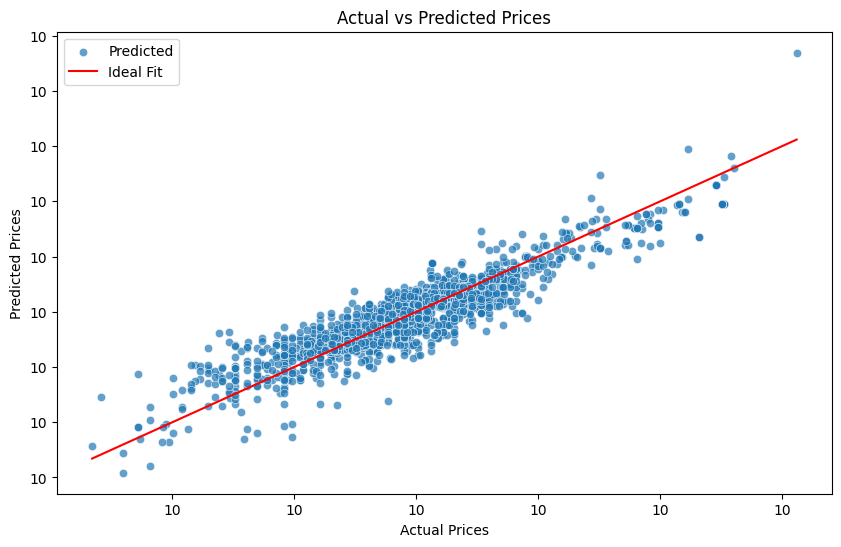

In [ ]:
plt.figure(figsize=(10,6))

# Scatterplot of actual vs predicted
sns.scatterplot(x=y_test, y=yhat, alpha=0.7, label='Predicted')

# Plot reference line y = x
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', label='Ideal Fit')

plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()


#### Residual Distribution

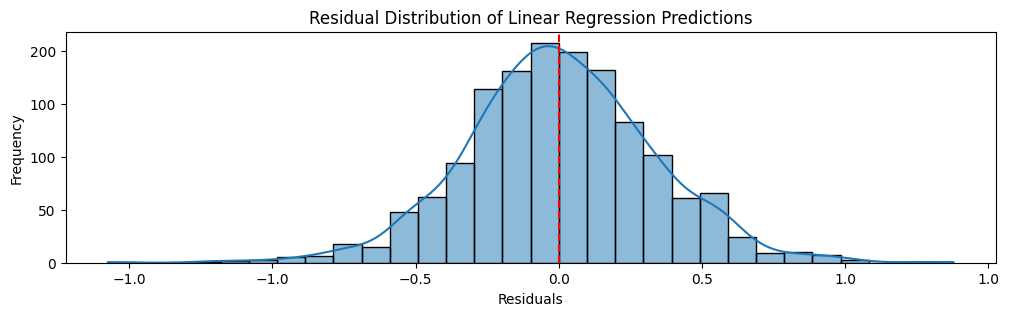

In [ ]:
residuals = y_test - yhat

plt.figure(figsize=(12,3))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution of Linear Regression Predictions")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='dashed')
plt.show()

## 8. Analysis: Feature Importance

As our actual and predicted prices are very near. The next step is to analyze the importance of each feature in the model. Extracting which feature is important for prediction can help us interpret the results. There are several ways: algorithm, permutation, and shap. Note that these techniques can be mostly applied to most algorithms.

#### Algorithmic / Coefficient-based Importance

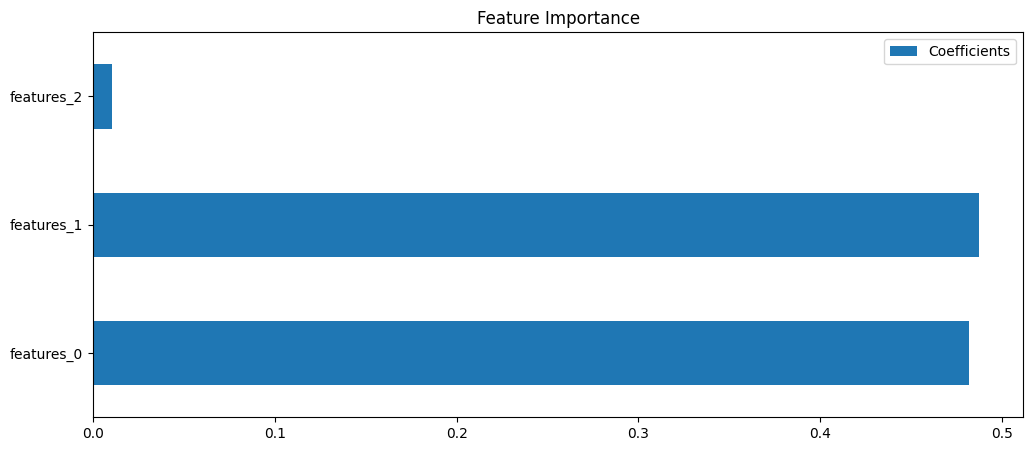

None


In [ ]:
fi = model.feature_importance(width=12, height=5)  # Display feature importance
print(fi)

#### Permutation way

This method will randomly shuffle each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important one.

*Note*: The permutation based importance is computationally expensive. The permutation based method can have problem with highly-correlated features, it can report them as unimportant.

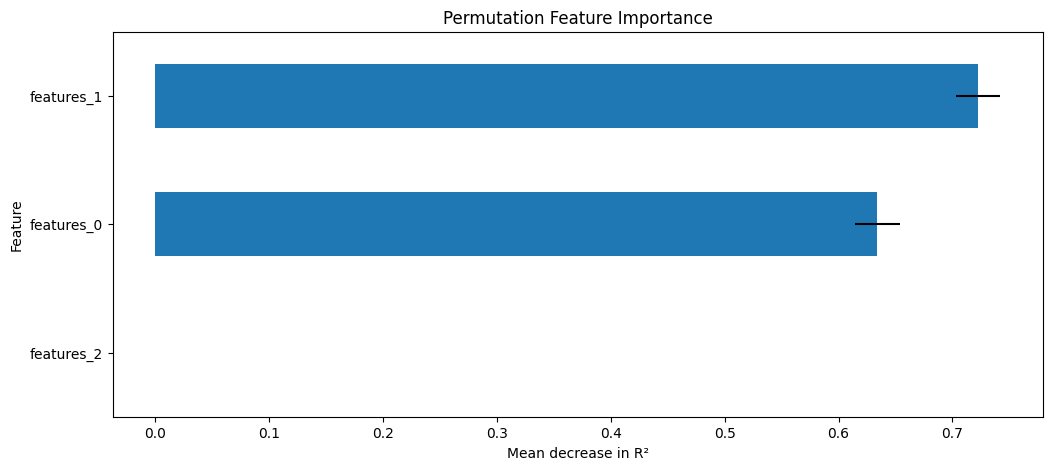

In [ ]:
from sklearn.inspection import permutation_importance


# permutation importance
perm_imp = permutation_importance(
    model,            # our model needs to have predict() method
    X_test,
    y_test.values if isinstance(y_test, pd.Series) else y_test,
    n_repeats=10,
    random_state=42,
    scoring='r2'
)

# Create a DataFrame for visualization
perm_df = pd.DataFrame({
    'Feature': model.columns,
    'Importance_Mean': perm_imp.importances_mean,
    'Importance_STD': perm_imp.importances_std
}).sort_values(by='Importance_Mean', ascending=True)

# Plot
perm_df.plot(kind='barh', x='Feature', y='Importance_Mean', figsize=(12,5), xerr='Importance_STD', legend=False)
plt.title("Permutation Feature Importance")
plt.xlabel("Mean decrease in R²")
plt.show()

#### Shap way

The SHAP interpretation can be used (it is model-agnostic) to compute the feature importances. It is using the Shapley values from game theory to estimate the how does each feature contribute to the prediction. It can be easily installed (<code>uv pip install shap</code>) 

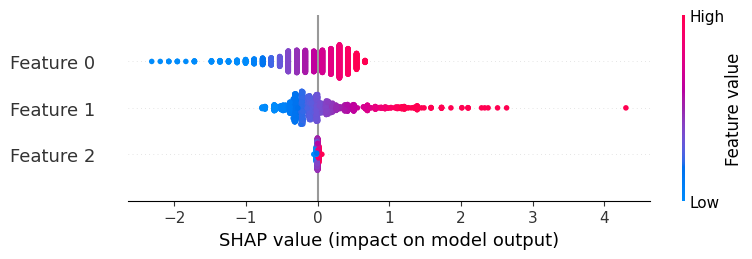

In [ ]:
import shap

# create an explainer for linear model
explainer = shap.Explainer(model.predict, X_test if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test, columns=model.columns))

# calculate SHAP values
shap_values = explainer(X_test)

# summary plot
shap.summary_plot(shap_values, X_test if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test, columns=model.columns))

## 9. Inference


To provide inference service or deploy, it's best to save the model for latter use.

In [ ]:
import joblib
# Save the model to a file
joblib.dump(model, 'model/cppm_a2_model.pkl')

['model/cppm_a2_model.pkl']

In [ ]:
joblib.dump(scaler, 'model/cppm_a2_scaler.pkl')

['model/cppm_a2_scaler.pkl']

In [ ]:
loaded_model = joblib.load('model/cppm_a2_model.pkl')
loaded_scaler = joblib.load('model/cppm_a2_scaler.pkl')

## 10. Example

In [ ]:
df.iloc[1]

brand               20.00
year              2000.00
selling_price   300000.00
km_driven       100000.00
fuel                 0.00
seller_type          1.00
transmission         1.00
owner                2.00
mileage             20.00
engine            1000.00
max_power          100.00
seats                5.00
Name: 1, dtype: float64

In [ ]:
sample = df[['year', 'max_power', 'mileage']].iloc[1].to_frame().T
sample

,year,max_power,mileage
1,2000.00,100.00,20.00


In [ ]:
sample = loaded_scaler.transform(sample)
sample

array([[0.04, 0.33, 0.44]])

In [ ]:
predicted_selling_price = loaded_model.predict(sample)
np.set_printoptions(precision=2)
print("Predicted Price: ", str(np.exp(predicted_selling_price)))

Predicted Price:  [521451.61]


In [ ]:
predicted_selling_price = model.predict(sample)
np.set_printoptions(precision=2)
print("Predicted Price: ", str(np.exp(predicted_selling_price)))

Predicted Price:  [521451.61]


# -------------- A2. Car Price Prediction Report ---------------

##### In this report, I discuss the findings from above machine learning experiment using MLflow. The goal of the experiment is to predict the selling price of cars using a dataset containing information about various car features. Screenshots of MLflow was captured throughout the experiment and will present a final table summarizing the model comparisons.

#### Experimental Setup:
- Features: ["year", "max_power", "mileage"]
- Target: ["selling_price"]

I experimented with the following models:
  - Ridge
  - Lasso
  - Elastic Net
  - Normal LR

For each model, I tested various configurations, including:
  - Feature transformations: Linear and Polynomial
  - Initialization: Xavier Initialization and Zero Initialization
  - Optimization: Stochastic Batch Gradient Descent
  - Momentum: With Momentum or Without Momentum
  - Learning Rates: 0.1, 0.01, 0.001, and 0.0001

#### Experiment Tracking:

<img src="https://drive.google.com/thumbnail?id=1Uo8nPpRa_kkvmQIZrTqaCp3fh3D_dsqr" alt="ML_Flow" width="">

<img src="https://drive.google.com/thumbnail?id=1FaPJ6EPKAERvOdOpWmFwmNGMXgQhIIwR" alt="Graph" width="">

<img src="https://drive.google.com/thumbnail?id=1ipjF9UyL0UctEgO0Ltq1659yM1FH3IWv" alt="R2_Graph" width="">

<img src="https://drive.google.com/thumbnail?id=17YW5i98O-aWFqbdbz5F33F2OnRPLuY2j" alt="MSE_Graph" width="">

##### The experiment tracking dashboard displaying car price prediction model runs, including model names, parameters, metrics such as mean squared error and R2 score, and run status. The dashboard interface is organized in a table format with columns for run name, start time, and performance metrics. The environment is a web-based workspace for machine learning experiment management. The tone is professional and focused on data analysis.

**Note:** To see the following images in higher resolution please follow this link:
`https://drive.google.com/drive/folders/1Iew43gLlJAjULGO4GMkp7ulqS5IelR2Q?usp=sharing`

After extensive experimentation, I found that the "Normal" model, configured with the following settings, performed the best:

- Feature Transformation: Linear
- Initialization: Xavier Initialization
- Optimization: Batch Gradient Descent
- Momentum: With Momentum
- Learning Rate: 0.01
